In [1]:
import pickle
import torch
import pytorch_lightning as pl
import pandas as pd
import numpy as np
from pathlib import Path
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from modules.action_recognizer.dataset.pose_dataset import PoseDataset, all_activities
from modules.action_recognizer.models.action_transformer.lit_action_transformer import LitActionTransformer
import shutil

pl.seed_everything(1234)

Seed set to 1234


1234

In [3]:
with open('output/inner_mirror_with_padding/pose_info_with_bone_velo.pkl', 'rb') as f:
    pose_df = pickle.load(f)

with open('output/inner_mirror_with_padding/annotation.pkl', 'rb') as f:
    annotation_df = pickle.load(f)

In [4]:
# split 0
# train 1,2,3,4,6,7,8,9,10,12
# val 14, 15
# test 5, 11, 13
train_participants = [1,2,3,4,6,7,8,9,10,12]
val_participants = [14, 15]
test_participants = [5, 11, 13]
train_data = annotation_df[annotation_df.participant_id.isin(train_participants)]

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from modules.action_recognizer.dataset.pose_dataset import all_activities


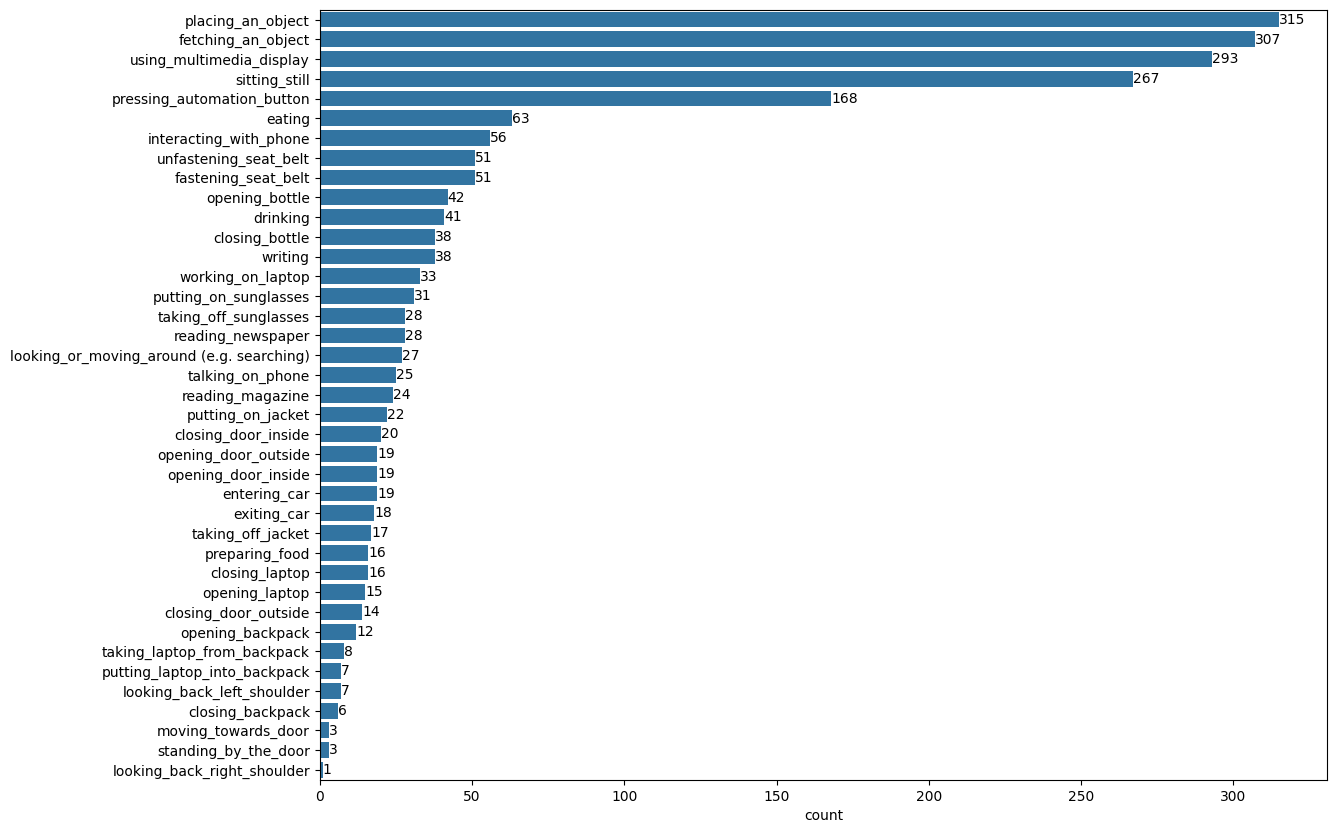

In [7]:
activity_count = train_data.value_counts('activity')

fig, ax = plt.subplots(figsize=(13,10))
p = sns.barplot(x=activity_count, y=activity_count.index.values)
ax.bar_label(ax.containers[0]);

In [11]:
train_data.loc[:, 'seq_length'] = train_data.frame_index_end - train_data.frame_index_start

[None]

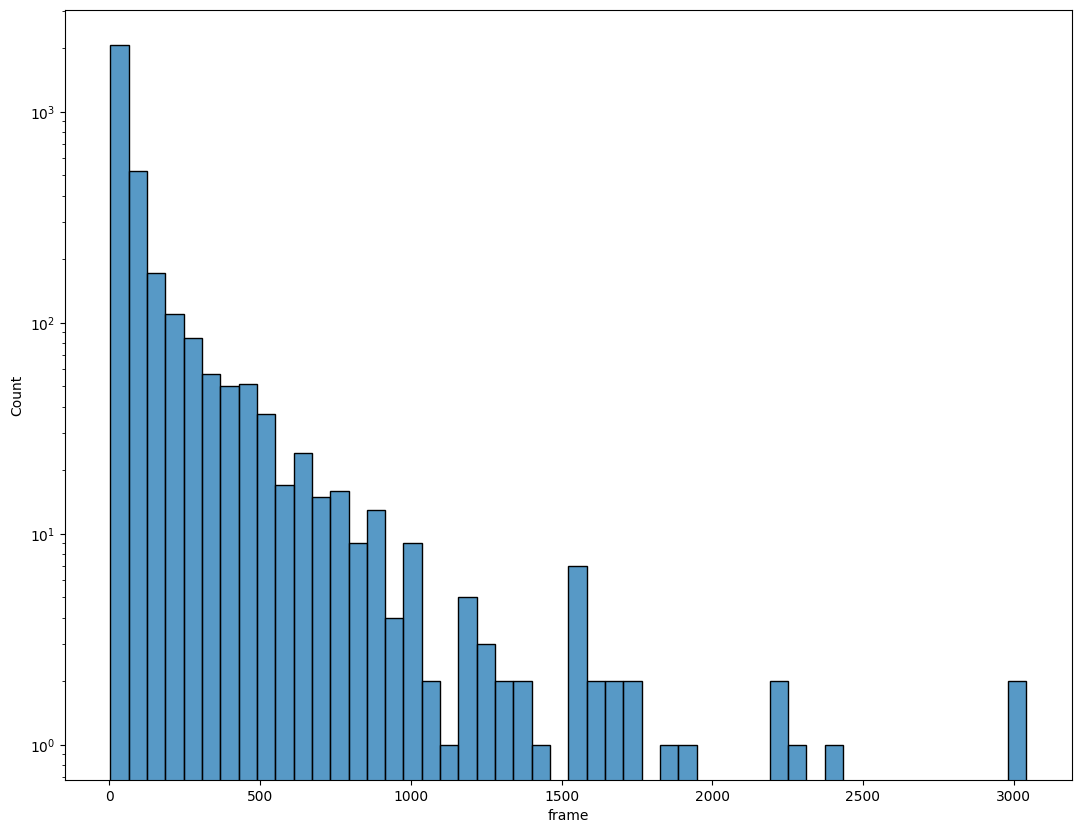

In [33]:
fig, ax = plt.subplots(figsize=(13,10))
seq_length = pose_df[pose_df.annotated_frame].groupby(['participant_id', 'video_name', 'annotation_id']).count()['frame']
p = sns.histplot(seq_length, bins=50)
ax.set(yscale="log")


In [59]:
tmp = seq_length.reset_index().groupby('frame').count().cumsum()['annotation_id']
tmp.name = 'proportion of sample'
cumsum = tmp / tmp.iloc[-1]

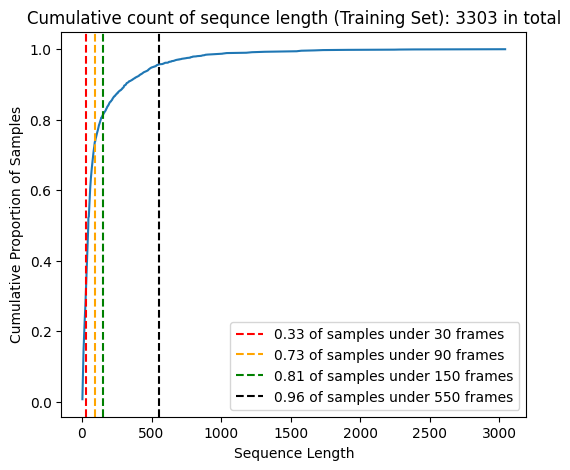

In [108]:
fig, ax = plt.subplots(figsize=(6,5))
p = sns.lineplot(cumsum / cumsum.iloc[-1])
ax.axvline(30, 0, 1, c='red', linestyle='--', label=f'{cumsum[30]:.2f} of samples under 30 frames')
ax.axvline(90, 0, 1, c='orange', linestyle='--', label=f'{cumsum[90]:.2f} of samples under 90 frames')
ax.axvline(150, 0, 1, c='green', linestyle='--', label=f'{cumsum[150]:.2f} of samples under 150 frames')
ax.axvline(550, 0, 1, c='black', linestyle='--', label=f'{cumsum[550]:.2f} of samples under 550 frames')
ax.set_title('Cumulative count of sequnce length (Training Set): 3303 in total')
ax.set_xlabel('Sequence Length')
ax.set_ylabel('Cumulative Proportion of Samples')
ax.legend()

In [123]:
tmp = pose_df.merge(train_data, left_on=['participant_id', 'video_name', 'annotation_id', 'activity'], right_on=['participant_id', 'video_name', 'annotation_id', 'activity'])

In [133]:
tmp[tmp.annotated_frame].groupby(['participant_id', 'video_name', 'annotation_id', 'activity']).count()['frame'].reset_index()\
    .groupby('activity').mean('frame')['frame'].sort_values(ascending=False).reset_index()

,activity,frame
0,reading_magazine,793.833333
1,reading_newspaper,495.821429
2,working_on_laptop,401.030303
3,talking_on_phone,370.720000
4,eating,338.174603
5,sitting_still,290.003745
6,putting_on_jacket,267.045455
7,interacting_with_phone,247.375000
8,writing,218.736842
9,taking_off_jacket,207.470588
